# Assignment 4: Language Processing with RNN-Based Autoencoders

**Deadline**: Sunday, June 15th, by 9pm.


**Submission**: Submit a PDF export of the completed notebook as well as the ipynb file. 

In this assignement, we will practice the application of deep learning to natural language processing.
We will be working with a subset of Reuters news headlines that are collected over 15 months,
covering all of 2019, plus a few months in 2018 and in a few months of this year.

In particular, we will be building an **autoencoder** of news headlines. The idea is similar
to the kind of image autoencoder we built in lecture: we will have an **encoder** that
maps a news headline to a vector embedding, and then a **decoder** that reconstructs
the news headline. Both our encoder and decoder networks will be Recurrent Neural Networks,
so that you have a chance to practice building

- a neural network that takes a sequence as an input
- a neural network that generates a sequence as an output

This assignment is organized as follows:

- Question 1. Exploring the data
- Question 2. Building the autoencoder
- Question 3. Training the autoencoder using *data augmentation*
- Question 4. Analyzing the embeddings (interpolating between headlines)

Furthermore, we'll be introducing the idea of **data augmentation** for improving of
the robustness of the autoencoder, as proposed by Shen et al [1] in ICML 2020.

[1] Shen, Tianxiao, Jonas Mueller, Regina Barzilay, and Tommi Jaakkola. "Educating text autoencoders: Latent representation guidance via denoising." In International Conference on Machine Learning, pp. 8719-8729. PMLR, 2020.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import random

import collections

## Question 1. Data (20 %)

Download the files `reuters_train.txt` and `reuters_valid.txt`, and upload them to Google Drive.

Then, mount Google Drive from your Google Colab notebook:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

train_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/Assignment4/reuters_train.txt' # Update me
valid_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/Assignment4/reuters_valid.txt' # Update me

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


As we did in some of our examples (e.g., training transformers on IMDB reviews) will be using PyTorch's `torchtext` utilities to help us load, process,
and batch the data. We'll be using a `TabularDataset` to load our data, which works well on structured
CSV data with fixed columns (e.g. a column for the sequence, a column for the label). Our tabular dataset
is even simpler: we have no labels, just some text. So, we are treating our data as a table with one field
representing our sequence.

In [4]:
import torchtext.legacy.data as data

# Tokenization function to separate a headline into words
def tokenize_headline(headline):
    """Returns the sequence of words in the string headline. We also
    prepend the "<bos>" or beginning-of-string token, and append the
    "<eos>" or end-of-string token to the headline.
    """
    return ("<bos> " + headline + " <eos>").split()

# Data field (column) representing our *text*.
text_field = data.Field(
    sequential=True,            # this field consists of a sequence
    tokenize=tokenize_headline, # how to split sequences into words
    include_lengths=True,       # to track the length of sequences, for batching
    batch_first=True,           # similar to batch_first=True used in nn.RNN demonstrated in lecture
    use_vocab=True)             # to turn each character into an integer index
train_data = data.TabularDataset(
    path=train_path,                # data file path
    format="tsv",                   # fields are separated by a tab
    fields=[('title', text_field)]) # list of fields (we have only one)

### Part (a) -- 5%

Draw histograms of the number of words per headline in our training set.
Excluding the `<bos>` and `<eos>` tags in your computation.
Explain why we would be interested in such histograms.

(array([2.3000e+01, 8.9000e+01, 2.9700e+02, 7.4000e+02, 2.1910e+03,
        6.1630e+03, 1.2529e+04, 2.0805e+04, 2.7921e+04, 2.9969e+04,
        2.6251e+04, 1.9511e+04, 1.2307e+04, 6.8520e+03, 0.0000e+00,
        3.3640e+03, 1.4980e+03, 6.0000e+02, 2.2700e+02, 7.7000e+01,
        1.4000e+01, 6.0000e+00, 3.0000e+00, 4.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 2.        ,  2.93103448,  3.86206897,  4.79310345,  5.72413793,
         6.65517241,  7.5862069 ,  8.51724138,  9.44827586, 10.37931034,
        11.31034483, 12.24137931, 13.17241379, 14.10344828, 15.03448276,
        15.96551724, 16.89655172, 17.82758621, 18.75862069, 19.68965517,
        20.62068966, 21.55172414, 22.48275862, 23.4137931 , 24.34482759,
        25.27586207, 26.20689655, 27.13793103, 28.06896552, 29.        ]),
 <a list of 29 Patch objects>)

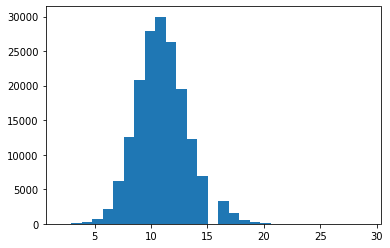

In [5]:
# Include your histogram and your written explanations
num_of_words = []
for sentence in train_data:   
   num_of_words.append(len(sentence.title)-2)
plt.hist(num_of_words, bins=max(num_of_words))   

# Here is an example of how to plot a histogram in matplotlib:
# plt.hist(np.random.normal(0, 1, 40), bins=20)

# Here are some sample code that uses the train_data object:
# print(train_data[5].title)
# for example in train_data:
#     print(example.title)
#     break

**Write your explanation here:**

We would be interested in this kind of histogram in order to see if the data distribution is like gaussian and justifies this assumption in Variational Autoencoders.

### Part (b) -- 5%

How many distinct words appear in the training data?
Exclude the `<bos>` and `<eos>` tags in your computation.

In [6]:
from six import print_
# Report your values here. Make sure that you report the actual values,
# and not just the code used to get those values

# You might find the python class Counter from the collections package useful
cnt = collections.Counter()
for sentence in train_data:
    if type(sentence.title) == list: 
      cnt.update([word for word in sentence.title[2:-1]]) 
print(f"number of distinct words: {len(cnt.keys())}")  

print(cnt["<bos>"])      # sanity check, needs to be zero

number of distinct words: 46289
0


### Part (c) -- 5%

The distribution of *words* will have a long tail, meaning that there are some words
that will appear very often, and many words that will appear infrequently. How many words
appear exactly once in the training set? Exactly twice?
Print these numbers below

In [7]:
# Report your values here. Make sure that you report the actual values,
# and not just the code used to get those values

def appearance_counter(cnt, n):  
  number_cnt = 0
  for value in cnt.values():
      if value == n:
        number_cnt += 1
  return number_cnt  

ones_cnt = appearance_counter(cnt, 1)
twos_cnt = appearance_counter(cnt, 2)

print(f"{ones_cnt} words appear exactly once in the training set")
print(f"{twos_cnt} words appear exactly twice in the training set")

16755 words appear exactly once in the training set
6688 words appear exactly twice in the training set


### Part (d) -- 5%
We will replace the infrequent
words with an `<unk>` tag, instead of learning embeddings for these rare words. `torchtext` also provides us with the `<pad>` tag used for padding short sequences for batching.
We will thus only model the top 9995 words in the training set, excluding the tags
`<bos>`, `<eos>`, `<unk>`, and `<pad>`.

What percentage of total word count(whole dataset) will be supported? Alternatively, what percentage
of total word count(whole dataset) in the training set will be set to the `<unk>` tag?

In [8]:
# Report your values here. Make sure that you report the actual values,
# and not just the code used to get those values

top_words = cnt.most_common()[1:9998]         # excluding the tags <bos>, <eos>
counter_top = sum([word_tuple[1] for word_tuple in top_words])
counter_total = sum(cnt.values())

print(f"{counter_top/counter_total*100}% of total word count will be supported") 
print(f"{(1-counter_top/counter_total)*100}% of total word count in the training set will be set to the <unk> tag") 

90.90601096187436% of total word count will be supported
9.093989038125638% of total word count in the training set will be set to the <unk> tag


The `torchtext` package will help us keep track of our list of unique words, known
as a **vocabulary**. A vocabulary also assigns a unique integer index to each word.

In [9]:
# Build the vocabulary based on the training data. The vocabulary
# can have at most 9997 words (9995 words + the <bos> and <eos> token)
text_field.build_vocab(train_data, max_size=9997)

# This vocabulary object will be helpful for us
vocab = text_field.vocab
print(vocab.stoi["hello"]) # for instances, we can convert from string to (unique) index
print(vocab.itos[10])      # ... and from word index to string

# The size of our vocabulary  
vocab_size = len(text_field.vocab.stoi) 
# Here are the two tokens that torchtext adds for us:
print(vocab.itos[0]) # <unk> represents an unknown word not in our vocabulary
print(vocab.itos[1]) # <pad> will be used to pad short sequences for batching   

0
on
<unk>
<pad>


## Question 2. Text Autoencoder (40%)

Building a text autoencoder is a little more complicated than an image autoencoder like we did in class. So
we will need to thoroughly understand the model that we want to build before actually building it. Note that the best and fastest way to complete this assignment is to spend time upfront understanding the architecture. The explanations are quite dense, but it is important to understand the operation of this model. The rationale here is similar in nature to the `seq2seq` RNN model we discussed in class, only we are dealing with unsupervised learning here rather than machine translation. 

# Architecture description
Here is a diagram showing our desired architecture:

<img src='https://drive.google.com/uc?id=1UaXAYQvmFbBcuSBQb7ozjSliuVn7bP1Q'>

There are two main components to the model: the **encoder** and the **decoder**.
As always with neural networks, we'll first describe how to make
**predictions** with of these components. Let's get started:

The **encoder** will take a sequence of words (a headline) as *input*, and produce an
embedding (a vector) that represents the entire headline. In the diagram above,
the vector ${\bf h}^{(7)}$ is the vector embedding containing information about 
the entire headline.  This portion is very similar
to the sentiment analysis RNN that we discussed in lecture (but without the fully-connected
layer that makes a prediction).

The **decoder** will take an embedding (in the diagram, the vector ${\bf h}^{(7)}$) as input,
and uses a separate RNN to **generate a sequence of words**. To generate a sequence of words,
the decoder needs to do the following:


1.   Determine the previous word that was generated. This previous word will act as ${\bf x}^{(t)}$
   to our RNN, and will be used to update the hidden state ${\bf m}^{(t)}$. Since each of our
   sequences begin with the `<bos>` token, we'll set ${\bf x}^{(1)}$ to be the `<bos>` token.
2.   Compute the updates to the hidden state ${\bf m}^{(t)}$ based on the previous hidden state
   ${\bf m}^{(t-1)}$ and ${\bf x}^{(t)}$. Intuitively, this hidden state vector ${\bf m}^{(t)}$
   is a representation of *all the words we still need to generate*.
3. We'll use a fully-connected layer to take a hidden state ${\bf m}^{(t)}$, and determine
   *what the next word should be*. This fully-connected layer solves a *classification problem*,
   since we are trying to choose a word out of $K=$ `vocab_size` distinct words. As in a classification
   problem, the fully-connected neural network will compute a *probability distribution* over
   these `vocab_size` words. In the diagram, we are using ${\bf z}^{(t)}$ to represent the logits,
   or the pre-softmax activation values representing the probability distribution.
4. We will need to *sample* an actual word from this probability distribution ${\bf z}^{(t)}$.
   We can do this in a number of ways, which we'll discuss in question 3. For now, you can 
   imagine your favourite way of picking a word given a distribution over words.
5. This word we choose will become the next input ${\bf x}^{(t+1)}$ to our RNN, which is used
   to update our hidden state ${\bf m}^{(t+1)}$, i.e., to determine what are the remaining
   words to be generated.

We can repeat this process until we see an `<eos>` token generated, or until the generated
sequence becomes too long.

# Training the architecture
While our autoencoder produces a sequence, computing the loss by comparing the complete generated sequence to the ground truth (the encoder input) gives rise to multiple challanges. One is that the generated
sequence might be longer or shorter than the actual sequence, meaning that there may
be more/fewer ${\bf z}^{(t)}$s than ground-truth words. Another more insidious issue
is that the **gradients will become very high-variance and unstable**, because
**early mistakes will easily throw the model off-track**. Early in training,
our model is unlikely to produce the right answer in step $t=1$, so the gradients
we obtain based on the other time steps will not be very useful.

At this point, you might have some ideas about "hacks" we can use to make training
work. Fortunately, there is one very well-established solution called
**teacher forcing** which we can use for training:
instead of *sampling* the next word based on ${\bf z}^{(t)}$, we will forget sampling,
and use the **ground truth** ${\bf x}^{(t)}$ as the input in the next step.

Here is a diagram showing how we can use **teacher forcing** to train our model:
 
<img src='https://drive.google.com/uc?id=1NXlimWaCviDfP8DHlIzyQR1Ie7sxfPuY'>

We will use the RNN generator to compute the logits
${\bf z}^{(1)},{\bf z}^{(2)},  \cdots {\bf z}^{(T)}$. These distributions
can be compared to the ground-truth words using the cross-entropy loss.
The loss function for this model will be the sum of the losses across each $t \in \{1,\ldots,T\}$.

We'll train the encoder and decoder model simultaneously. There are several components
to our model that contain tunable weights:

- The word embedding that maps a word to a vector representation.
  In theory, we could use GloVe embeddings, as we did in class. In this assignment we will not do that, but learn the word embedding from data.
  The word embedding component is represented with blue arrows in the diagram.
- The encoder RNN (which will use GRUs) that computes the
  embedding over the entire headline. The encoder RNN 
  is represented with black arrows in the diagram.
- The decoder RNN (which will also use GRUs) that computes
  hidden states, which are vectors representing what words are to be generated.
  The decoder RNN is represented with gray arrows in the diagram.
- The **projection MLP** (a fully-connected layer) that computes
  a distribution over the next word to generate, given a decoder RNN hidden
  state. The projection is represented with green arrows 



## Part (a) -- 20%

Complete the code for the AutoEncoder class below by:

1. Filling in the missing numbers in the `__init__` method using
   the parameters `vocab_size`, `emb_size`, and `hidden_size`.  
2. Complete the `forward` method, which uses teacher forcing
   and computes the logits ${\bf z}^{(t)}$ of the reconstruction of
   the sequence. 

You should first try to understand the `encode` and `decode` methods,
which are written for you. The `encode` method bears much similarity to the
RNN we wrote in class for sentiment analysis.  The `decode` method is
a bit more challenging. You might want to scroll down to the
`sample_sequence` function to see how this function will be called.

You can (but don't have to) use the `encode` and `decode` method in
your `forward` method. In either case, be careful of the input
that you feed into ether `decode` or to `self.decoder_rnn`.
Refer to the teacher-forcing diagram.
**bold text** Notice that batch_first is set to True, understand how deal with it.

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        """
        A text autoencoder. The parameters 
            - vocab_size: number of unique words/tokens in the vocabulary
            - emb_size: size of the word embeddings $x^{(t)}$
            - hidden_size: size of the hidden states in both the
                           encoder RNN ($h^{(t)}$) and the
                           decoder RNN ($m^{(t)}$)
        """
        super().__init__()
        self.embed = nn.Embedding(num_embeddings=vocab_size, # TODO
                                  embedding_dim=emb_size)  # TODO
        self.encoder_rnn = nn.GRU(input_size=emb_size, #TODO
                                  hidden_size=hidden_size, #TODO
                                  batch_first=True)
        self.decoder_rnn = nn.GRU(input_size=emb_size, #TODO
                                  hidden_size=hidden_size, #TODO
                                  batch_first=True)
        self.proj = nn.Linear(in_features=emb_size, # TODO
                              out_features=vocab_size) # TODO

    def encode(self, inp):
        """
        Computes the encoder output given a sequence of words.
        """
        emb = self.embed(inp)
        out, last_hidden = self.encoder_rnn(emb)
        return last_hidden

    def decode(self, inp, hidden=None):
        """
        Computes the decoder output given a sequence of words, and
        (optionally) an initial hidden state.
        """
        emb = self.embed(inp)
        out, last_hidden = self.decoder_rnn(emb, hidden)
        out_seq = self.proj(out)
        return out_seq, last_hidden

    def forward(self, inp):
        """
        Compute both the encoder and decoder forward pass
        given an integer input sequence inp with shape [batch_size, seq_length],
        with inp[a,b] representing the (index in our vocabulary of) the b-th word
        of the a-th training example.

        This function should return the logits $z^{(t)}$ in a tensor of shape
        [batch_size, seq_length - 1, vocab_size], computed using *teaching forcing*.

        The (seq_length - 1) part is not a typo. If you don't understand why
        we need to subtract 1, refer to the teacher-forcing diagram above.
        """

        x = self.encode(inp)
        [x, last_hidden] = self.decode(inp[:,:-1], hidden=x)
        return x

### Part (b) -- 10%

To check that your model is set up correctly, we'll train our autoencoder
neural network for at least 300 iterations to memorize this sequence:

In [11]:
headline = train_data[42].title
input_seq = torch.Tensor([vocab.stoi[w] for w in headline]).long().unsqueeze(0)

We are looking for the way that you set up your loss function
corresponding to the figure above.
Be  careful of off-by-one errors here.


Note that the Cross Entropy Loss expects a rank-2 tensor as its first
argument (the output of the network), and a rank-1 tensor as its second argument (the true label). You will
need to properly reshape your data to be able to compute the loss.

In [29]:
model = AutoEncoder(vocab_size, 128, 128)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
for it in range(300):
    optimizer.zero_grad()
    pred = model(input_seq)

    loss = sum([criterion(pred[:,word_idx,:], input_seq[:,word_idx+1]) for word_idx in range(0,pred.shape[1])])
    loss.backward()
    optimizer.step()

    if (it+1) % 50 == 0:
        print("[Iter %d] Loss %f" % (it+1, float(loss)))

[Iter 50] Loss 2.114422
[Iter 100] Loss 0.438728
[Iter 150] Loss 0.255385
[Iter 200] Loss 0.172325
[Iter 250] Loss 0.125750
[Iter 300] Loss 0.096644


### Part (c) -- 4%

Once you are satisfied with your model, encode your input using
the RNN encoder, and sample some sequences from the decoder. The 
sampling code is provided to you, and performs the computation
from the first diagram (without teacher forcing).

Note that we are sampling from a multi-nomial distribution described
by the logits $z^{(t)}$. For example, if our distribution is [80%, 20%]
over a vocabulary of two words, then we will choose the first word
with 80% probability and the second word with 20% probability.

Call `sample_sequence` at least 5 times, with the default temperature
value. Make sure to include the generated sequences in your PDF
report.

In [13]:
def sample_sequence(model, hidden, max_len=20, temperature=1):
    """
    Return a sequence generated from the model's decoder
        - model: an instance of the AutoEncoder model
        - hidden: a hidden state (e.g. computed by the encoder)
        - max_len: the maximum length of the generated sequence
        - temperature: described in Part (d)
    """
    # We'll store our generated sequence here
    generated_sequence = []
    # Set input to the <BOS> token
    inp = torch.Tensor([text_field.vocab.stoi["<bos>"]]).long()
    for p in range(max_len):
        # compute the output and next hidden unit
        output, hidden = model.decode(inp.unsqueeze(0), hidden)
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0])
        # Add predicted word to string and use as next input
        word = text_field.vocab.itos[top_i]
        # Break early if we reach <eos>
        if word == "<eos>":
            break
        generated_sequence.append(word)
        inp = torch.Tensor([top_i]).long()
    return generated_sequence

# Your solutions go here
for i in range(1,10):
    output = sample_sequence(model, model.encode(input_seq), max_len=20, temperature=1)
    print(' '.join(output))

president swears in new army chief
president swears in new army chief
president swears in new army chief
president swears in new army chief
president swears in new army chief
president swears in new army chief
president swears in new army chief
president swears in new army chief
president swears in new army chief


### Part (d) -- 6%

The multi-nomial distribution can be manipulated using the `temperature`
setting. This setting can be used to make the distribution "flatter" (e.g.
more likely to generate different words) or "peakier" (e.g. less likely
to generate different words).

Call `sample_sequence` at least 5 times each for at least 3 different
temperature settings (e.g. 1.5, 2, and 5). Explain why we generally
don't want the temperature setting to be too **large**.

In [14]:
temperatures_list = [1.5,2,5]
for temperature in temperatures_list:
    print(f"Temperature:{temperature}")
    for i in range(1,6):
        output = sample_sequence(model, model.encode(input_seq), 10, temperature)
        print(' '.join(output))

Temperature:1.5
president swears in new revenues l.a. roberts hurricanes extending
president swears in new chief asia-pacific ibm crown burns pool
wishes president facilities in blessing naphtha slots chief
al president stir summons utrecht havens _num_-lebanon president swears in
president swears new army cenovus mandate rbi rare _num_-allergan council
Temperature:2
diet managers president mate oilfields sberbank burn even ranks opt
_num_-union friend scenario am work actor da bleak grid sotheby
furniture rooney attacker several ac advances profit fine tria axes
mediate defies passports evacuate winning revoke ongoing offences chad swears
debt angels relief ranks label privatbank revolution branch idai slow
Temperature:5
polish miller bilateral adapt trigger usgs stockholm stands trio bidens
mothers avenatti secretive higher task identify stole scottish target dodge
_num_-gm flowers breach dealing condition negotiating hundreds three-week soybean maximum
d -white hefty monte allowing 

We don't want the temperature setting to be too large because 

## Question 3. Data augmentation (20%)

It turns out that getting good results from a text auto-encoder is very difficult,
and that it is very easy for our model to **overfit**. We have discussed several methods
that we can use to prevent overfitting, and we'll introduce one more today:
**data augmentation**.

The idea behind data augmentation is to artificially increase the number of training
examples by "adding noise" to the image. For example, during AlexNet training,
the authors randomly cropped $224\times 224$
regions of a $256 \times 256$ pixel image to increase the amount of training data.
The authors also flipped the image left/right.
Machine learning practitioners can also add Gaussian noise to the image.

When we use data augmentation to train an *autoencoder*, we typically to only add
the noise to the input, and expect the reconstruction to be *noise free*.
This makes the task of the autoencoder even more difficult. An autoencoder trained
with noisy inputs is called a **denoising auto-encoder**. For simplicity, we will
*not* build a denoising autoencoder today.



### Part (a) -- 5%

We will add noise to our headlines using a few different techniques:

1. Shuffle the words in the headline, taking care that words don't end up too far from where they were initially
2. Drop (remove) some words 
3. Replace some words with a blank word (a `<pad>` token)
4. Replace some words with a random word 

The code for adding these types of noise is provided for you:

In [15]:
def tokenize_and_randomize(headline,
                           drop_prob=0.1,  # probability of dropping a word
                           blank_prob=0.1, # probability of "blanking" out a word
                           sub_prob=0.1,   # probability of substituting a word with a random one
                           shuffle_dist=3): # maximum distance to shuffle a word
    """
    Add 'noise' to a headline by slightly shuffling the word order,
    dropping some words, blanking out some words (replacing with the <pad> token)
    and substituting some words with random ones.
    """
    headline = [vocab.stoi[w] for w in headline.split()]
    n = len(headline)
    # shuffle
    headline = [headline[i] for i in get_shuffle_index(n, shuffle_dist)]

    new_headline = [vocab.stoi['<bos>']]
    for w in headline:
        if random.random() < drop_prob:
            # drop the word
            pass
        elif random.random() < blank_prob:
            # replace with blank word
            new_headline.append(vocab.stoi["<pad>"])
        elif random.random() < sub_prob:
            # substitute word with another word
            new_headline.append(random.randint(0, vocab_size - 1))
        else:
            # keep the original word
            new_headline.append(w)
    new_headline.append(vocab.stoi['<eos>'])
    return new_headline

def get_shuffle_index(n, max_shuffle_distance):
    """ This is a helper function used to shuffle a headline with n words,
    where each word is moved at most max_shuffle_distance. The function does
    the following: 
       1. start with the *unshuffled* index of each word, which
          is just the values [0, 1, 2, ..., n]
       2. perturb these "index" values by a random floating-point value between
          [0, max_shuffle_distance]
       3. use the sorted position of these values as our new index
    """
    index = np.arange(n)
    perturbed_index = index + np.random.rand(n) * 3
    new_index = sorted(enumerate(perturbed_index), key=lambda x: x[1])
    return [index for (index, pert) in new_index]

Call the function `tokenize_and_randomize` 5 times on a headline of your
choice. Make sure to include both your original headline, and the five new
headlines in your report.

In [16]:
# Report your values here. Make sure that you report the actual values,
# and not just the code used to get those values
headline = ' '.join(train_data[74].title)
print(f"Original headline: {headline}")
for i in range(1,6):
    new_headline = tokenize_and_randomize(headline[1:-1],drop_prob=i*0.05,blank_prob=i*0.05,sub_prob=i*0.05,shuffle_dist=i//2)
    new_headline = [vocab.itos[w] for w in new_headline]

    print(f"Augmented headline {str(i)}: {' '.join(new_headline)}")

Original headline: <bos> four injured after german man rams car into crowd ; racist motive suspected <eos>
Augmented headline 1: <bos> <unk> four after injured german <pad> car rams into crowd ; racist motive suspected <unk> <eos>
Augmented headline 2: <bos> <unk> four injured german soda man car into crowd <pad> ; <pad> suspected <eos>
Augmented headline 3: <bos> four <pad> heart august german whole car rams crowd into ; motive racist <eos>
Augmented headline 4: <bos> four <pad> <pad> german rams <pad> <pad> into alex racist co-ceo suspected <pad> <eos>
Augmented headline 5: <bos> forbes <unk> rams carbon car cheered wipro <pad> motive suspected <unk> <eos>


### Part (b) -- 8%

The training code that we use to train the model is mostly provided for you. 
The only part we left blank are the parts from Q2(b). Complete the code,
and train a new AutoEncoder model for 1 epoch. You can train your model
for longer if you want, but training tend to take a long time,
so we're only checking to see that your training loss is trending down.

If you are using Google Colab, you can use a GPU for this portion.
Go to "Runtime" => "Change Runtime Type"  and set "Hardware acceleration" to GPU.
Your Colab session will restart.
You can move your model to the GPU by typing `model.cuda()`, and move
other tensors to GPU (e.g. `xs = xs.cuda()`). To move a model back to CPU,
type `model.cpu`. To move a tensor back, use `xs = xs.cpu()`. For training,
your model and inputs need to be on the *same device*.

[Iter 100] Loss 1.317274
[Iter 200] Loss 1.318532
[Iter 300] Loss 1.334772
[Iter 400] Loss 1.358983
[Iter 500] Loss 1.290647
[Iter 600] Loss 1.312251
[Iter 700] Loss 1.378311
[Iter 800] Loss 1.380834
[Iter 900] Loss 1.385908
[Iter 1000] Loss 1.324356
[Iter 1100] Loss 1.353541
[Iter 1200] Loss 1.327914
[Iter 1300] Loss 1.306422
[Iter 1400] Loss 1.238425
[Iter 1500] Loss 1.325863
[Iter 1600] Loss 1.313924
[Iter 1700] Loss 1.301462
[Iter 1800] Loss 1.402642
[Iter 1900] Loss 1.294062
[Iter 2000] Loss 1.224812
[Iter 2100] Loss 1.275530
[Iter 2200] Loss 1.339367
[Iter 2300] Loss 1.314300
[Iter 2400] Loss 1.313043
[Iter 2500] Loss 1.337606
[Iter 2600] Loss 1.325805
[Iter 100] Loss 1.310410
[Iter 200] Loss 1.352960
[Iter 300] Loss 1.275603
[Iter 400] Loss 1.326438
[Iter 500] Loss 1.337089
[Iter 600] Loss 1.274916
[Iter 700] Loss 1.290160
[Iter 800] Loss 1.272155
[Iter 900] Loss 1.266332
[Iter 1000] Loss 1.301392
[Iter 1100] Loss 1.294101
[Iter 1200] Loss 1.236915
[Iter 1300] Loss 1.316245
[Ite

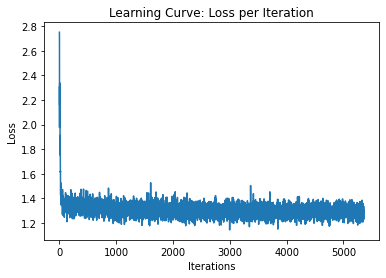

In [30]:
def train_autoencoder(model, batch_size=64, learning_rate=0.001, num_epochs=10):
    model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    train_loss = []
    valid_loss = []
    train_iters = []
    valid_iters = []
    train_n = 0
    valid_n = 0
    for ep in range(num_epochs):
        # We will perform data augmentation by re-reading the input each time
        field = data.Field(sequential=True,
                                     tokenize=tokenize_and_randomize, # <-- data augmentation
                                     include_lengths=True,
                                     batch_first=True,
                                     use_vocab=False, # <-- the tokenization function replaces this
                                     pad_token=vocab.stoi['<pad>'])
        dataset = data.TabularDataset(train_path, "tsv", [('title', field)])
        # dataset_valid = data.TabularDataset(valid_path, "tsv", [('title', field)])
        # This BucketIterator will handle padding of sequences that are not of the same length
        train_iter = data.BucketIterator(dataset, batch_size=batch_size,
                                                   sort_key=lambda x: len(x.title), # to minimize padding
                                                   repeat=False)
        # valid_iter = data.BucketIterator(dataset_valid, batch_size=batch_size,
        #                                            sort_key=lambda x: len(x.title), # to minimize padding
        #                                            repeat=False)              

        for it, ((xs, lengths), _) in enumerate(train_iter):
            xs = xs.cuda()
            train_n += 1
            train_iters.append(train_n)
            optimizer.zero_grad()
            zs = model(xs)
            loss = sum([criterion(zs[:,word_idx,:], xs[:,word_idx+1]) for word_idx in range(0,zs.shape[1])])
            train_loss.append(loss)
            loss.backward()
            optimizer.step()

            if (it+1) % 100 == 0:
                print("[Iter %d] Loss %f" % (it+1, float(loss)))

        # # Optional: Compute and track validation loss
        # val_loss = 0
        # val_n = 0
        # for it, ((xs, lengths), _) in enumerate(valid_iter):
        #    xs = xs.cuda()
        #    valid_n += 1
        #    valid_iters.append(valid_n)
        #    zs = model(xs)
        #    loss = sum([criterion(zs[:,word_idx,:], xs[:,word_idx+1]) for word_idx in range(1,zs.shape[1])])  # TODO
        #    valid_loss.append(loss)
        #    val_loss += float(loss)

    return train_loss, valid_loss, train_iters, valid_iters

# Include your training curve or output to show that your training loss is trending down
def plot_learning_curve(train_loss, valid_loss, train_iters, valid_iters):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(train_iters, train_loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    # plt.title("Learning Curve: Loss per Iteration")
    # plt.plot(valid_iters, valid_loss, label="Validation")
    # plt.xlabel("Iterations")
    # plt.ylabel("Loss")
    # plt.show()

torch.cuda.empty_cache()
model = AutoEncoder(vocab_size, 128, 128)

[train_loss, valid_loss, train_iters, valid_iters] = train_autoencoder(model, batch_size=64, learning_rate=0.001, num_epochs=2)

plot_learning_curve(train_loss, valid_loss, train_iters, valid_iters)    

### Part (c) -- 7%

This model requires many epochs (>50) to train, and is quite slow without using a GPU.
You can train a model yourself, or you can load the model weights that we have trained,
and available on the course website (AE_RNN_model.pk).

Assuming that your `AutoEncoder` is set up correctly, the following code should run without
error.

In [18]:
model = AutoEncoder(10000, 128, 128)
checkpoint_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/Assignment4/AE_RNN_model.pk' # Update me
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

Then, repeat your code from Q2(d), for `train_data[10].title`
with temperature settings 0.7, 0.9, and 1.5.
Explain why we generally don't want the temperature setting to
be too **small**.

In [19]:
# Include the generated sequences and explanation in your PDF report.

headline = train_data[10].title
input_seq = torch.Tensor([vocab.stoi[w] for w in headline]).unsqueeze(0).long()

temperatures_list = [0.7,0.9,1.5]
for temperature in temperatures_list:
    print(f"Temperature:{temperature}")
    for i in range(1,6):
        output = sample_sequence(model, model.encode(input_seq), 20, temperature)
        print(' '.join(output))

Temperature:0.7
wall street rises , limps die win at marred to region big dogs
wall street rises , limps die win at of sciences election four
wall street rises , limps across the finish line of a turbulent year
wall street rises , limps die win at $ <pad> after change computing
wall street rises , limps die win at of sciences <pad> presidential amid
Temperature:0.9
wall street rises , limps die win 's spread - <pad> digital in
wall street rises , limps across no-confidence to aug australian deal fire cheers
wall street rises , limps open sentence , concert high libya : survival
wall street rises , limps die win 's employees <pad> but january sports
wall street rises , limps die win onshore _num_ <pad> ; misconduct talks
Temperature:1.5
wall street rises respite <unk> tighter takes night for pinned europe since themes
wall street rises , _num_-cruise trumps final challenge on <pad> three after ipos
wall street rises , limps form atlantia after to 'll southern big quarter
wall 's ambev a

**Write your explanation here:**

We don't want the temperature setting to be too small because


## Question 4. Latent space manipulations (20%)

In parts 2-3, we've explored the decoder portion of the autoencoder. In this section,
let's explore the **encoder**. In particular, the encoder RNN gives us 
embeddings of news headlines!

First, let's load the **validation** data set:

In [20]:
valid_data = data.TabularDataset(
    path=valid_path,                # data file path
    format="tsv",                   # fields are separated by a tab
    fields=[('title', text_field)]) # list of fields (we have only one)

### Part (a) -- 4%

Compute the embeddings of every item in the validation set. Then, store the
result in a single PyTorch tensor of shape `[19046, 128]`, since there are
19,046 headlines in the validation set.

In [21]:
valid_embedded = torch.zeros(19046, 128)    # a PyTorch tensor of shape [19046, 128]
for i in range(0,len(valid_data)):
    
    headline = valid_data[i].title
    input_seq = torch.Tensor([vocab.stoi[w] for w in headline]).long().unsqueeze(0)
    valid_embedded[i,:] = model.encode(input_seq)

print(valid_embedded.shape)

torch.Size([19046, 128])


### Part (b) -- 4%

Find the 5 closest headlines to the headline `valid_data[13]`. Use the
cosine similarity to determine closeness. (Hint: You can use code from assignment 2)

In [22]:
# Write your code here. Make sure to include the actual 5 closest headlines.
model.cpu
# headline_emb_weights = list(model.embed.parameters())[0]
# headline_emb = headline_emb_weights.detach().numpy().T

# norms = np.linalg.norm(headline_emb, axis=0)
# headline_emb_norm = (headline_emb / norms).T
# similarities = np.matmul(headline_emb_norm, headline_emb_norm.T)

def find_closest_headlines(valid_embedded,input_seq,headline):
    headline_emb = model.encode(input_seq)
    closest_headlines = {}
    headline_norm = headline_emb.detach().numpy()/np.linalg.norm(headline_emb.detach().numpy())

    for hl in range(0,np.size(valid_embedded,0)):
        dist = abs(np.matmul(headline_norm,valid_embedded[hl].detach().numpy())/\
                   np.linalg.norm(valid_embedded[hl].detach().numpy()))
    
        if len(closest_headlines.keys()) < 5:
            closest_headlines[hl] = dist
        else:
            hl_maxdist = max(closest_headlines, key=closest_headlines.get)
            if closest_headlines[hl_maxdist] > dist:
              closest_headlines.pop(hl_maxdist)
              closest_headlines[hl] = dist
    
    print('The five closest headlines to "{}":'.format(' '.join(headline)))
    for hl in closest_headlines.keys():
        print(' '.join(valid_data[hl].title))

headline = valid_data[13].title
input_seq = torch.Tensor([vocab.stoi[w] for w in headline]).long().unsqueeze(0)
find_closest_headlines(valid_embedded,input_seq,headline)   

The five closest headlines to "<bos> asia takes heart from new year gains in u.s. stock futures <eos>":
<bos> a-league standings <eos>
<bos> update _num_-eredivisie results <eos>
<bos> update _num_-bundesliga standings <eos>
<bos> update _num_-bundesliga results <eos>
<bos> a-league summaries <eos>


### Part (c) -- 4%

Find the 5 closest headlines to another headline of your choice.

In [23]:
# Write your code here. 
# Make sure to include the original headline and the 5 closest headlines.

headline = valid_data[10000].title
input_seq = torch.Tensor([vocab.stoi[w] for w in headline]).long().unsqueeze(0)
find_closest_headlines(valid_embedded,input_seq,headline) 

The five closest headlines to "<bos> south korea august exports tumble for ninth month as world economy cools <eos>":
<bos> a-league standings <eos>
<bos> update _num_-eredivisie results <eos>
<bos> update _num_-bundesliga standings <eos>
<bos> update _num_-bundesliga results <eos>
<bos> a-league summaries <eos>


### Part (d) -- 8%

Choose two headlines from the validation set, and find their embeddings.
We will **interpolate** between the two embeddings like we did in the example presented in class for training autoencoders on MNIST.

Find 3 points, equally spaced between the embeddings of your headlines.
If we let $e_0$ be the embedding of your first headline and $e_4$ be
the embedding of your second headline, your three points should be:

\begin{align*}
e_1 &=  0.75 e_0 + 0.25 e_4 \\
e_2 &=  0.50 e_0 + 0.50 e_4 \\
e_3 &=  0.25 e_0 + 0.75 e_4 \\
\end{align*}

Decode each of $e_1$, $e_2$ and $e_3$ five times, with a temperature setting
that shows some variation in the generated sequences. Try to get a logical and cool sentence (this might be hard).

In [24]:
# Write your code here. Include your generated sequences.